In [97]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

In [98]:


# t = np.linspace(0, 100, 1000)
# data = np.sin(t)

# def create_sequences(data, seq_length):
#     xs, ys = [], []
#     for i in range(len(data) - seq_length):
#         x = data[i:(i + seq_length)]
#         y = data[i + seq_length]
#         xs.append(x)
#         ys.append(y)
#     return np.array(xs), np.array(ys)\

# seq_length = 15
# X, y = create_sequences(data, seq_length)

# trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
# trainY = torch.tensor(y[:, None], dtype=torch.float32)




In [99]:
import csv
import os
import pandas as pd


path = os.path.join("../../data", "integrated_data_20251028_192929.csv")
df = pd.read_csv(path)


print("DataFrame shape:", df.shape)
print("Columns:", list(df.columns))
print("\nFirst 5 rows:")
print(df.head())

numeric_columns = ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 
                   'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

data = df[numeric_columns].values.astype(np.float32)

print(f"\nNumeric data shape: {data.shape}")
print("First 5 rows of numeric data:")
print(data[:5])



DataFrame shape: (244, 17)
Columns: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label']

First 5 rows:
                    timestamp  iteration  env0  raw0  env1  raw1  env2  raw2  \
0  2025-10-28T19:29:38.090328          0   267   553   339   430   521   531   
1  2025-10-28T19:29:38.196658          1   310   553   480   436   471   529   
2  2025-10-28T19:29:38.304339          2   445   553   174   436   550   529   
3  2025-10-28T19:29:38.414687          3   445   553   573   430   315   526   
4  2025-10-28T19:29:38.528557          4   452   564   344   429   529   522   

   env3  raw3  thumb_tip  thumb_base   index  middle  ring   pinky hand_label  
0   428   442        1.0      0.6846  0.9894  1.0000   1.0  0.9036      Right  
1   374   442        1.0      0.6711  0.9817  0.9976   1.0  0.9063      Right  
2   371   439        1.0      0.6726  0.9772  0.9957   1.0  

In [100]:
sensor_columns = ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
finger_columns = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']
sensor_indices = [df.columns.get_loc(col)-1 for col in sensor_columns]
finger_indices = [df.columns.get_loc(col)-1 for col in finger_columns]

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length, :]  
        y = data[i + seq_length, :]   
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Split data into 80% train, 20% test BEFORE creating sequences
split_ratio = 0.8
split_index = int(len(data) * split_ratio)

train_data = data[:split_index]
test_data = data[split_index:]

print(f"Total data points: {len(data)}")
print(f"Train data points: {len(train_data)}")
print(f"Test data points: {len(test_data)}")

# Create sequences separately for train and test
seq_length = 15
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
trainX = torch.tensor(X_train[:, :, sensor_indices], dtype=torch.float32)
trainY = torch.tensor(y_train[:, finger_indices], dtype=torch.float32)
testX = torch.tensor(X_test[:, :, sensor_indices], dtype=torch.float32)
testY = torch.tensor(y_test[:, finger_indices], dtype=torch.float32)

print(f"\ntrainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")
print(f"testX shape: {testX.shape}")
print(f"testY shape: {testY.shape}")


Total data points: 244
Train data points: 195
Test data points: 49

trainX shape: torch.Size([180, 15, 9])
trainY shape: torch.Size([180, 6])
testX shape: torch.Size([34, 15, 9])
testY shape: torch.Size([34, 6])


In [101]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

In [102]:
model = LSTMModel(input_dim=9, hidden_dim=200, layer_dim=4, output_dim=6)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [103]:
num_epochs = 100
h0, c0 = None, None
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    h0, c0 = h0.detach(), c0.detach()
    
    model.eval()
    with torch.no_grad():
        val_outputs, _, _ = model(testX, None, None)
        val_loss = criterion(val_outputs, testY)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1152
Epoch [20/100], Loss: 0.1000
Epoch [30/100], Loss: 0.0975
Epoch [40/100], Loss: 0.0952
Epoch [50/100], Loss: 0.0954
Epoch [60/100], Loss: 0.0951
Epoch [70/100], Loss: 0.0951
Epoch [80/100], Loss: 0.0951
Epoch [90/100], Loss: 0.0951
Epoch [100/100], Loss: 0.0951


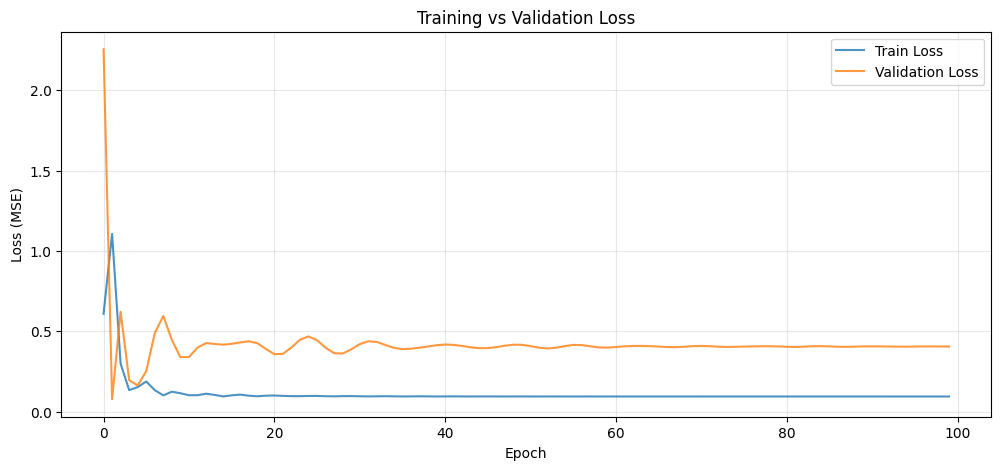


Final Train Loss: 0.0951
Final Validation Loss: 0.4055


In [104]:
# Plot training and validation losses
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

In [105]:
# Save the trained model
model_save_path = "../../models/lstm_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ../../models/lstm_model.pth


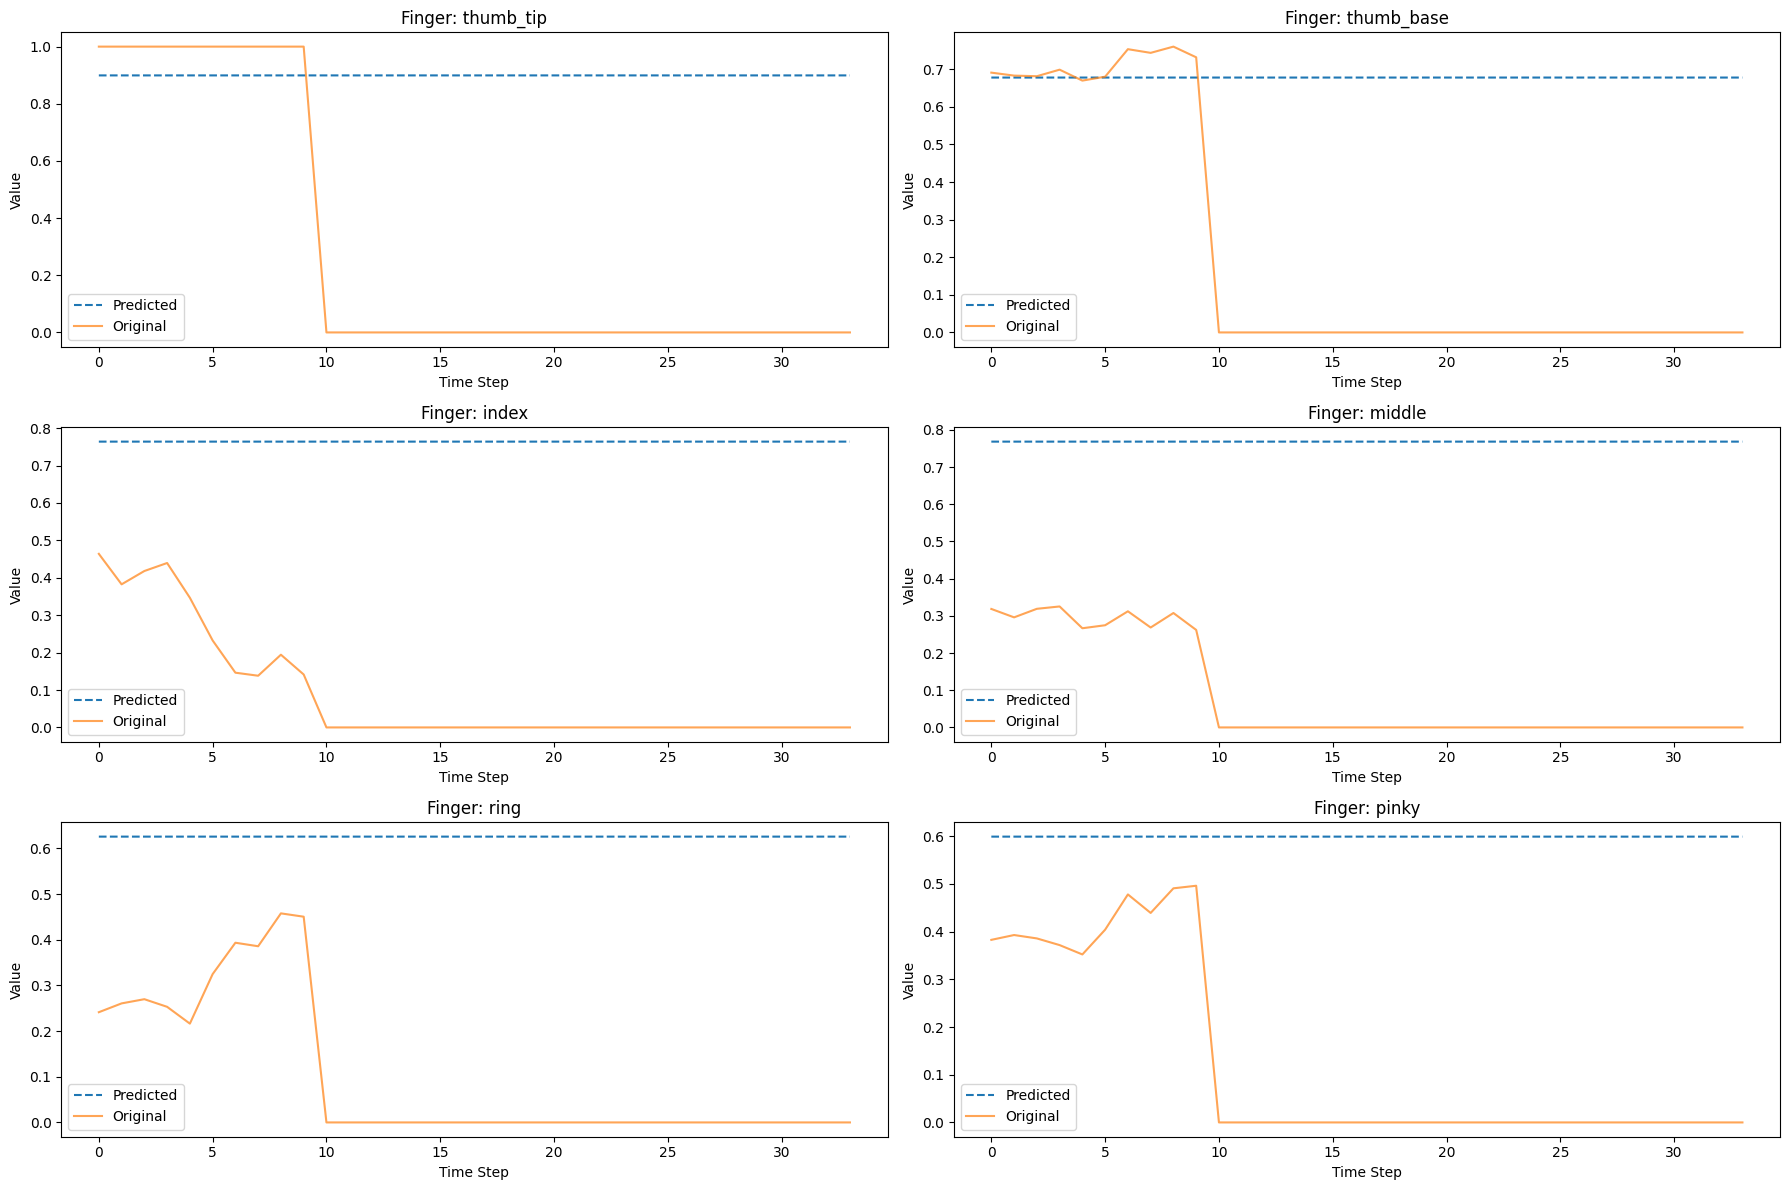

In [107]:
model.eval()
with torch.no_grad():
    predicted, _, _ = model(testX, None, None)


predicted = predicted.detach().numpy() 
original = testY.numpy()  


# Create plots for each finger
plt.figure(figsize=(18, 12))
for i, finger in enumerate(finger_columns):
    plt.subplot(3, 2, i + 1)  # Create a subplot for each finger
    plt.plot(predicted[:, i], label='Predicted', linestyle='--')
    plt.plot(original[:, i], label='Original', alpha=0.7)
    plt.title(f"Finger: {finger}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()